In [16]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torchvision.transforms as transforms
import torch.nn.functional as F

In [17]:
Root_Path = "/content/drive/MyDrive/학교/TNT/fashion_mnist"

In [18]:
transform = transforms.Compose(
    [
     transforms.ToTensor(),
])

In [19]:
LEARNING_RATE = 1e-3
BATCH_SIZE = 64
EPOCHS = 5

In [32]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [20]:
class MNISTDataset(Dataset):
    def __init__(self, mode, transform):
        self.X = pd.read_csv(Root_Path + "/fashion-mnist_" + mode + ".csv").iloc[:, 1:]
        self.y = pd.read_csv(Root_Path + "/fashion-mnist_" + mode + ".csv").iloc[:, 0]
        self.transforms = transform

    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):

        data = self.X.iloc[i, :]
        data = np.asarray(data).astype(np.float32).reshape(28, 28, 1)
        data = self.transforms(data)
        label = torch.from_numpy(np.asarray(self.y[i]).astype(np.long))
        return data, label

In [21]:
train_dataset = MNISTDataset("train", transform)
test_dataset = MNISTDataset("test", transform)

In [22]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)

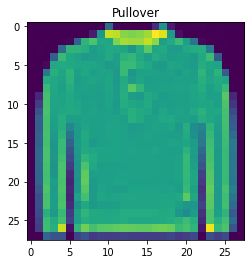

In [33]:
for (x, y) in train_loader:
    plt.figure()
    plt.imshow(x[0].reshape(28, -1))
    plt.title(class_names[y[0]])
    plt.show()
    break

In [24]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.flatten = nn.Flatten()
        self.input = nn.Linear(28*28, 512)
        self.layer_1 = nn.Linear(512, 256)
        self.layer_2 = nn.Linear(512, 256)
        self.layer_1_2 = nn.Linear(256, 64)
        self.layer_2_2 = nn.Linear(256, 32)
        self.output = nn.Linear(96, 10)
 
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.input(x))
        x1 = F.relu(self.layer_1(x))
        x2 = F.relu(self.layer_2(x))
        x1 = F.relu(self.layer_1_2(x1))
        x2 = F.relu(self.layer_2_2(x2))
        concat_x = torch.cat((x1, x2), dim = -1)
        logits = self.output(concat_x)
        return logits

In [25]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda:0 device


In [26]:
model = Model().to(device)

print(model)

Model(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (input): Linear(in_features=784, out_features=512, bias=True)
  (layer_1): Linear(in_features=512, out_features=256, bias=True)
  (layer_2): Linear(in_features=512, out_features=256, bias=True)
  (layer_1_2): Linear(in_features=256, out_features=64, bias=True)
  (layer_2_2): Linear(in_features=256, out_features=32, bias=True)
  (output): Linear(in_features=96, out_features=10, bias=True)
)


In [27]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [28]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [29]:
def main():
    for t in range(EPOCHS):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, model, loss_fn, optimizer, device)
        test_loop(test_loader, model, loss_fn, device)
    print("Done!")

In [30]:
if __name__ == "__main__":
    main()

Epoch 1
-------------------------------
loss: 8.152701  [    0/60000]
loss: 0.554818  [ 6400/60000]
loss: 0.660507  [12800/60000]
loss: 0.517812  [19200/60000]
loss: 0.515114  [25600/60000]
loss: 0.337878  [32000/60000]
loss: 0.556472  [38400/60000]
loss: 0.368683  [44800/60000]
loss: 0.465525  [51200/60000]
loss: 0.620165  [57600/60000]
Test Error: 
 Accuracy: 83.9%, Avg loss: 0.454344 

Epoch 2
-------------------------------
loss: 0.455230  [    0/60000]
loss: 0.431863  [ 6400/60000]
loss: 0.526917  [12800/60000]
loss: 0.464490  [19200/60000]
loss: 0.322301  [25600/60000]
loss: 0.368786  [32000/60000]
loss: 0.529838  [38400/60000]
loss: 0.480398  [44800/60000]
loss: 0.818528  [51200/60000]
loss: 0.465801  [57600/60000]
Test Error: 
 Accuracy: 85.4%, Avg loss: 0.408172 

Epoch 3
-------------------------------
loss: 0.329003  [    0/60000]
loss: 0.386851  [ 6400/60000]
loss: 0.510994  [12800/60000]
loss: 0.410840  [19200/60000]
loss: 0.419711  [25600/60000]
loss: 0.343929  [32000/600

Label :  T-shirt/top
Test :  T-shirt/top


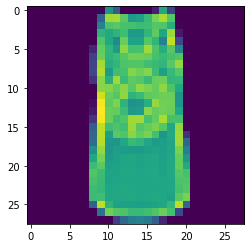

In [42]:
for (x, y) in test_loader:
    plt.figure()
    x = x.to(device)
    plt.imshow(x.cpu().data.numpy()[0].reshape(28, -1))
    print("Label : ", class_names[y[0]])
    print("Test : ", class_names[model(x)[0].argmax().data])
    plt.show()
    break